<a href="https://colab.research.google.com/github/stefanogiagu/PHDMIB_2025/blob/main/notebooks/AE_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Representation Learning e Anomaly Detection con Auto-Encoders

goal: get aquainted with design and application of AE architectures and Anomaly Detection

DL tool: pytorch

### tasks ###

1.   implementation of an AE trained as information compressor and comparison with PCA
2.    use of an AE as Anomaly Detection algorithm and application to the MNIST dataset
3.    exercise part: train the AE for AD for decays of long lived particles in a high energy physics detector


**Datasets:**

*   [MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST)
*   LLP: "images" representing hits in a detector (drift tubes) of prompt decays (normal events) and decays from neutral particles with macroscopic lifetime (anomalous events).

In [1]:
# impotr of the needed libraires
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

from torch import nn
import torch.nn.functional as F

2.6.0+cu124
0.21.0+cu124


MNIST dataset is made of images of handwritten digits (0,1,...,9) corresponding to 60k immages for training and 10k for test.

Each image has shape $(28,28)$ pixels, with one channel of intensity (8 bit grey scale: eg intensity of each pixel $\in [0,255]$).

In [2]:
# read MONIST using openml and sklearn library

from sklearn.datasets import fetch_openml

images, labels = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas")
labels = labels.astype(int) # converts labels in int

print(images.shape)
print(labels.shape)

(70000, 784)
(70000,)


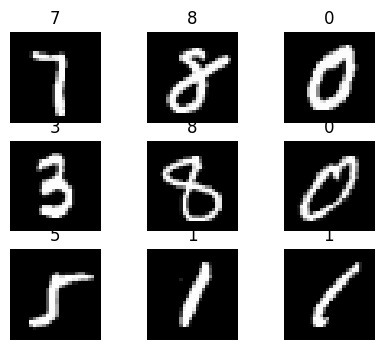

In [3]:
# plot of 9 random images from MNIST
figure = plt.figure(figsize=(5, 4))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(images))
    img, label = images[sample_idx], labels[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.reshape((28,28)), cmap="gray")
plt.show()

In [4]:
# splitting (80:20)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, shuffle=True, random_state=12345)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(56000, 784)
(56000,)
(14000, 784)
(14000,)


In [5]:
# normalized in [0.1] the features (makes faster and more stable training)

X_train = X_train / 255.
X_test  = X_test / 255.

In [6]:
# use GPU
if torch.cuda.is_available():
  print('Number of available GPUs: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Number of available GPUs:  1
Tesla T4
Computation device: cuda



In [7]:
# numpy -> torch conversion

X_train_pt = torch.Tensor(X_train).float()
Y_train_pt = torch.Tensor(Y_train).int()
X_test_pt = torch.Tensor(X_test).float()
Y_test_pt = torch.Tensor(Y_test).int()

# reshape of tensors from (n,784) to (n,1,28,28)=(event, channel, h size, v size) to be used in pytorch conv layers

X_train_pt = X_train_pt.view((X_train_pt.shape[0],1,28,28))
X_test_pt = X_test_pt.view((X_test_pt.shape[0],1,28,28))

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([56000, 1, 28, 28])
torch.Size([56000])
torch.Size([14000, 1, 28, 28])
torch.Size([14000])


In [8]:
# dataset and dataloaders

batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt)
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)

dataset_test = TensorDataset(X_test_pt, Y_test_pt)
test_dl = DataLoader(dataset_test, batch_size=1, shuffle=True, drop_last=True)

### neural network model definition

Auto-Encoder architecture: a convolutional AE with Encoder with 2 convolutional layers )kernel size 4, stride 2 (for compression), and Decoder with ConvTranspose2D upsampling convolutions.
The latent space z si made with a Dense layer.
We use ReLU activations in the convolutional parts and sigmoid output (so that output will be in [0,1] and we can train the models using BCELoss, that works tipicaly better than MSE for AD tasks).

In [9]:
# Convolutional Encoder Model

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=hidden_channels,
                            stride=2,
                                 kernel_size=4,
                                padding=1)
        self.conv2 = nn.Conv2d(in_channels=hidden_channels,
                               out_channels=hidden_channels*2,
                               kernel_size=4,
                               stride=2,
                               padding=1) # output: hidden_channels x 2 x 7 x 7

        self.fc_z = nn.Linear(in_features=hidden_channels*2*7*7,
                               out_features=latent_dim)

        self.activation = nn.ReLU()

    def forward(self, x):

        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))

        x = x.flatten(start_dim=1) #flatten da [-1, 2*hidden channels, 7, 7] a [-1, 2*hidden channels*7*7]

        z = self.fc_z(x)

        return z

In [10]:
# Convolutional Decoder Model
# based on nn.ConvTranspose2d transpose convolution layers

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim,
                            out_features=hidden_channels*2*7*7)

        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2,
                                        out_channels=hidden_channels,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels,
                                        out_channels=1,
                                        kernel_size=4,
                                        stride=2,
                                        padding=1)

        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels*2, 7, 7)
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

In [11]:
# Full AE Model

class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)       # x-> z
        x_recon = self.decoder(z) # z -> x'

        return x_recon

In [12]:
# Instanziate the model

hidden_channels = 64 #number of convolutional filters in the first conv. layer
latent_dim = 2 #dimension if the latents space z (we compress from D=28x28 -> d=2)

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_ae = AE(encoder, decoder)

print(model_ae)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model_ae.cuda(), input_size=(1,28,28))
else:
  summary(model_ae, input_size=(1,28,28))

AE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_z): Linear(in_features=6272, out_features=2, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=6272, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation): ReLU()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,088
              ReLU-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         131,200
              ReLU-4            [-1, 128, 7, 7]               0
            Linear-5                    [-1, 2]

In [13]:
# test over a batch

model_ae=model_ae.to(device)

x,_ = next(iter(train_dl)) #we don't need labels in an AE (input = output)

x=x.to(device)

z = encoder(x)
xtilde = model_ae(x)


print(z.shape)
print(xtilde.shape)

torch.Size([128, 2])
torch.Size([128, 1, 28, 28])


In [14]:
# Training


hidden_channels = 64
latent_dim = 2

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_ae = AE(encoder, decoder)

model_ae = model_ae.to(device)

# Loss Binary CrossEntropy
ae_loss = nn.BCELoss()

# Optimizer
LR = 1.e-3
opt = torch.optim.Adam(params=model_ae.parameters(), lr=LR, weight_decay=1e-5)

In [15]:
# Training loop ... only training here for computation speed but in general you should monitor on validation as well!

import time

epochs = 60
hist_loss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model_ae.train()
    train_loss = 0
    counter = 0

    for xb, _ in train_dl:
        counter += 1
        xb=xb.to(device)

        xhat = model_ae(xb)
        loss = ae_loss(xhat, xb)

        train_loss += loss.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    hist_loss.append(train_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f"
          % (epoch+1, elapsed_time, train_loss))

epoch: 1, time(s): 2.9521, train loss: 0.231485
epoch: 2, time(s): 2.4274, train loss: 0.206005
epoch: 3, time(s): 2.4434, train loss: 0.200825
epoch: 4, time(s): 2.4681, train loss: 0.197876
epoch: 5, time(s): 2.5307, train loss: 0.195729
epoch: 6, time(s): 2.5477, train loss: 0.194237
epoch: 7, time(s): 2.9847, train loss: 0.192706
epoch: 8, time(s): 2.5430, train loss: 0.191799
epoch: 9, time(s): 2.7618, train loss: 0.190878
epoch: 10, time(s): 3.2058, train loss: 0.189960
epoch: 11, time(s): 2.6219, train loss: 0.189304
epoch: 12, time(s): 3.0412, train loss: 0.188592
epoch: 13, time(s): 2.5277, train loss: 0.188137
epoch: 14, time(s): 2.5820, train loss: 0.187565
epoch: 15, time(s): 2.5556, train loss: 0.187249
epoch: 16, time(s): 2.5455, train loss: 0.186772
epoch: 17, time(s): 2.5536, train loss: 0.186357
epoch: 18, time(s): 2.5703, train loss: 0.186060
epoch: 19, time(s): 2.6209, train loss: 0.185725
epoch: 20, time(s): 2.5724, train loss: 0.185534
epoch: 21, time(s): 2.5901, t

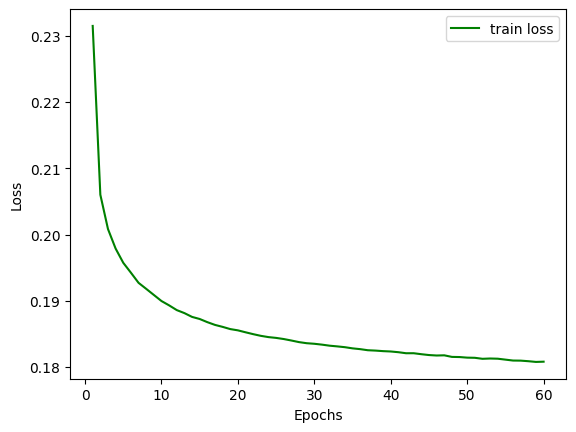

In [16]:
# training loss plot
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

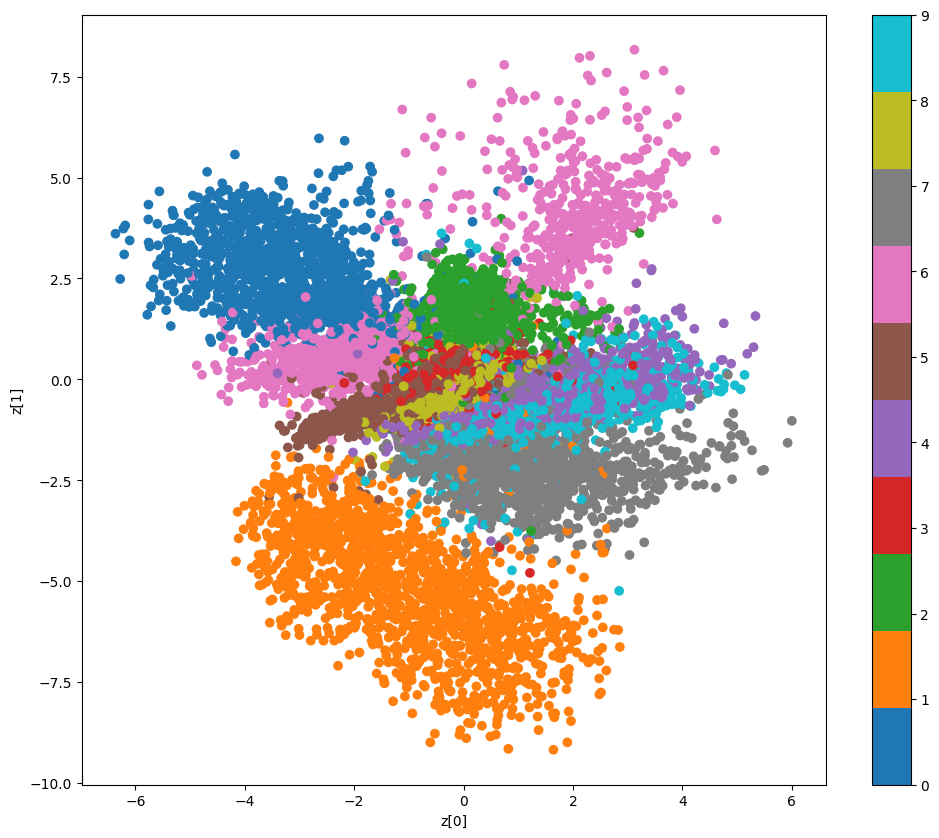

In [17]:
# Plot of the latent space (z1 vs z2) learned by the AE

model_ae.eval()

z = np.empty(shape=(len(test_dl),2))
y = np.empty(shape=(len(test_dl)))
counter = 0
with torch.no_grad():
  for idx, (xb, yb) in enumerate(test_dl):
    xb=xb.to(device)
    zl = encoder(xb)
    z[idx,0] = zl[0,0].item()
    z[idx,1] = zl[0,1].item()
    y[idx] = yb.item()

plt.figure(figsize=(12, 10))
plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

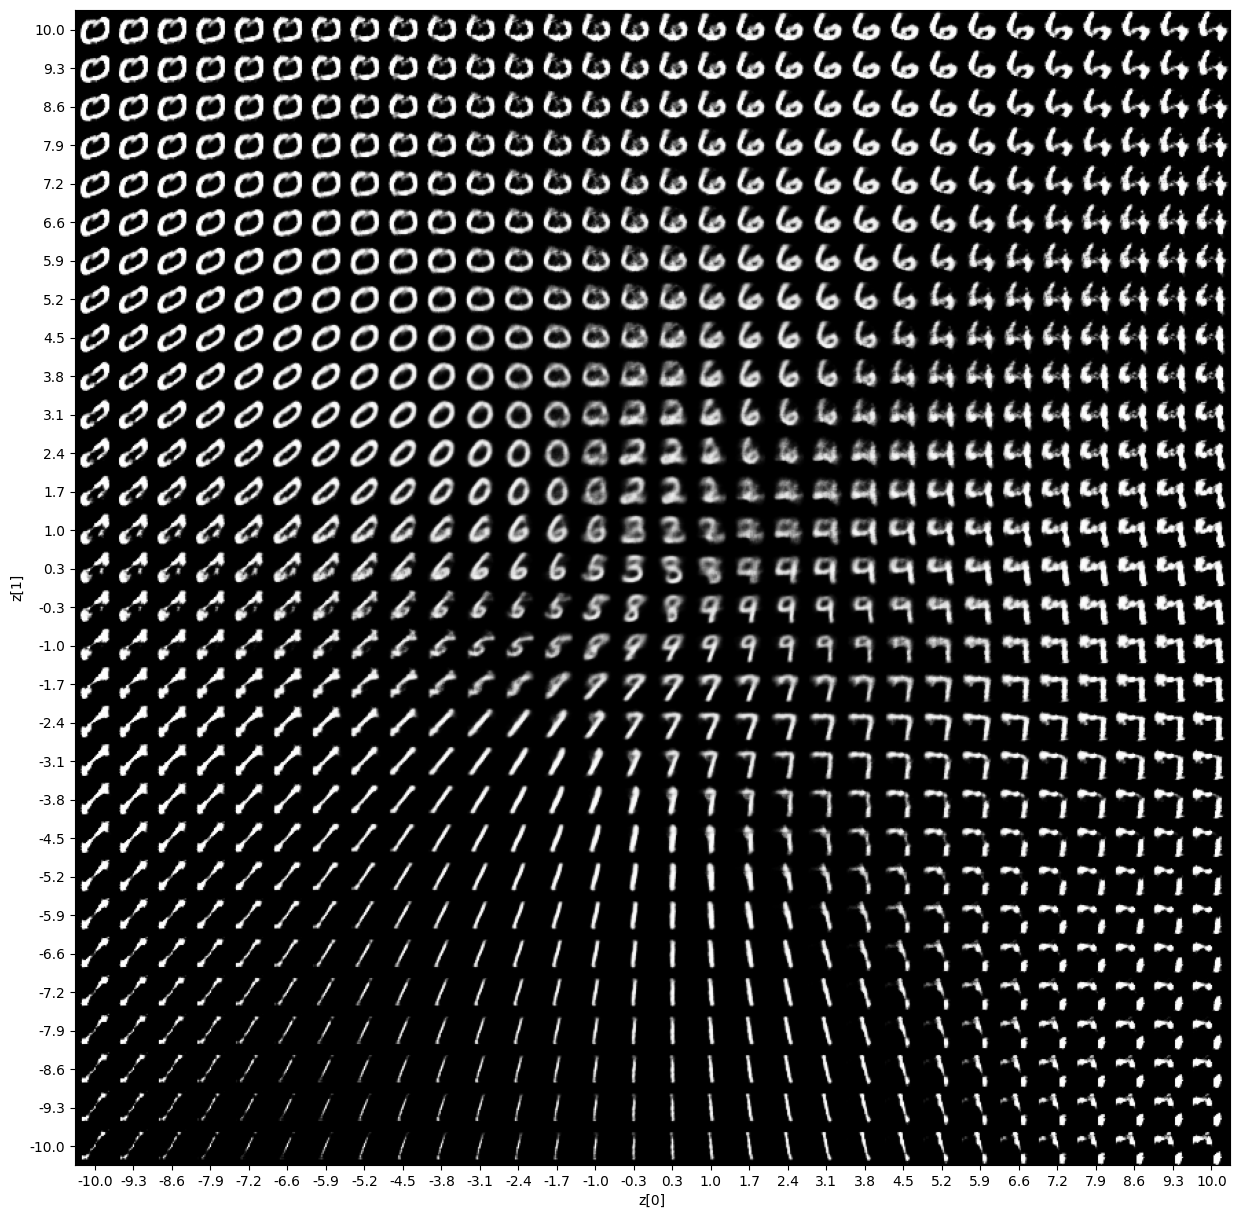

In [18]:
# plot of the maps latent space z -> output space (reconstructed input)

# draw a matrix nxn of images generated by the AE decoder from a grid ov values z1,z2

model_ae.eval()
def plot_latent(decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 10
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([xi, yi]).float() #vector z
            z_sample = z_sample.view(1,2)
            z_sample=z_sample.to(device)
            x_decoded = decoder(z_sample) #decoder(z)
            x_decoded=x_decoded.cpu()
            digit = x_decoded[0].view(28,28).detach().numpy() #(1,28,28) -> (28,28)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    #print(pixel_range)
    #print(sample_range_x)
    #print(sample_range_y)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent(decoder)

**Comparison with PCA**

explained variance componente:  0  =  0.09771438416479682
explained variance componente:  1  =  0.07274583508097827
Total explained variance of the first 2 PCA components: 0.1704602192457751


Text(0, 0.5, '$PCA_1$')

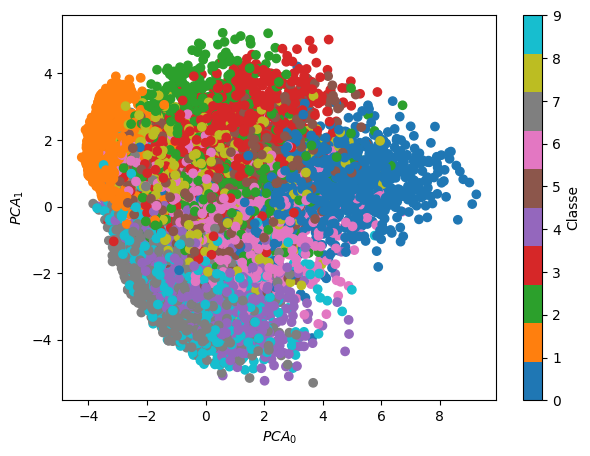

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca_result = pca.fit_transform(X_test)

exp_var = pca.explained_variance_ratio_

for i in range(0,len(exp_var)):
  print('explained variance componente: ',i, ' = ', exp_var[i])
print('Total explained variance of the first 2 PCA components: {}'.format(sum(exp_var)))

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.scatter(pca_result[:,0], pca_result[:,1], c=Y_test, cmap='tab10')
cbar = plt.colorbar()
cbar.set_label('Classe')
plt.xlabel('$PCA_0$')
plt.ylabel('$PCA_1$')

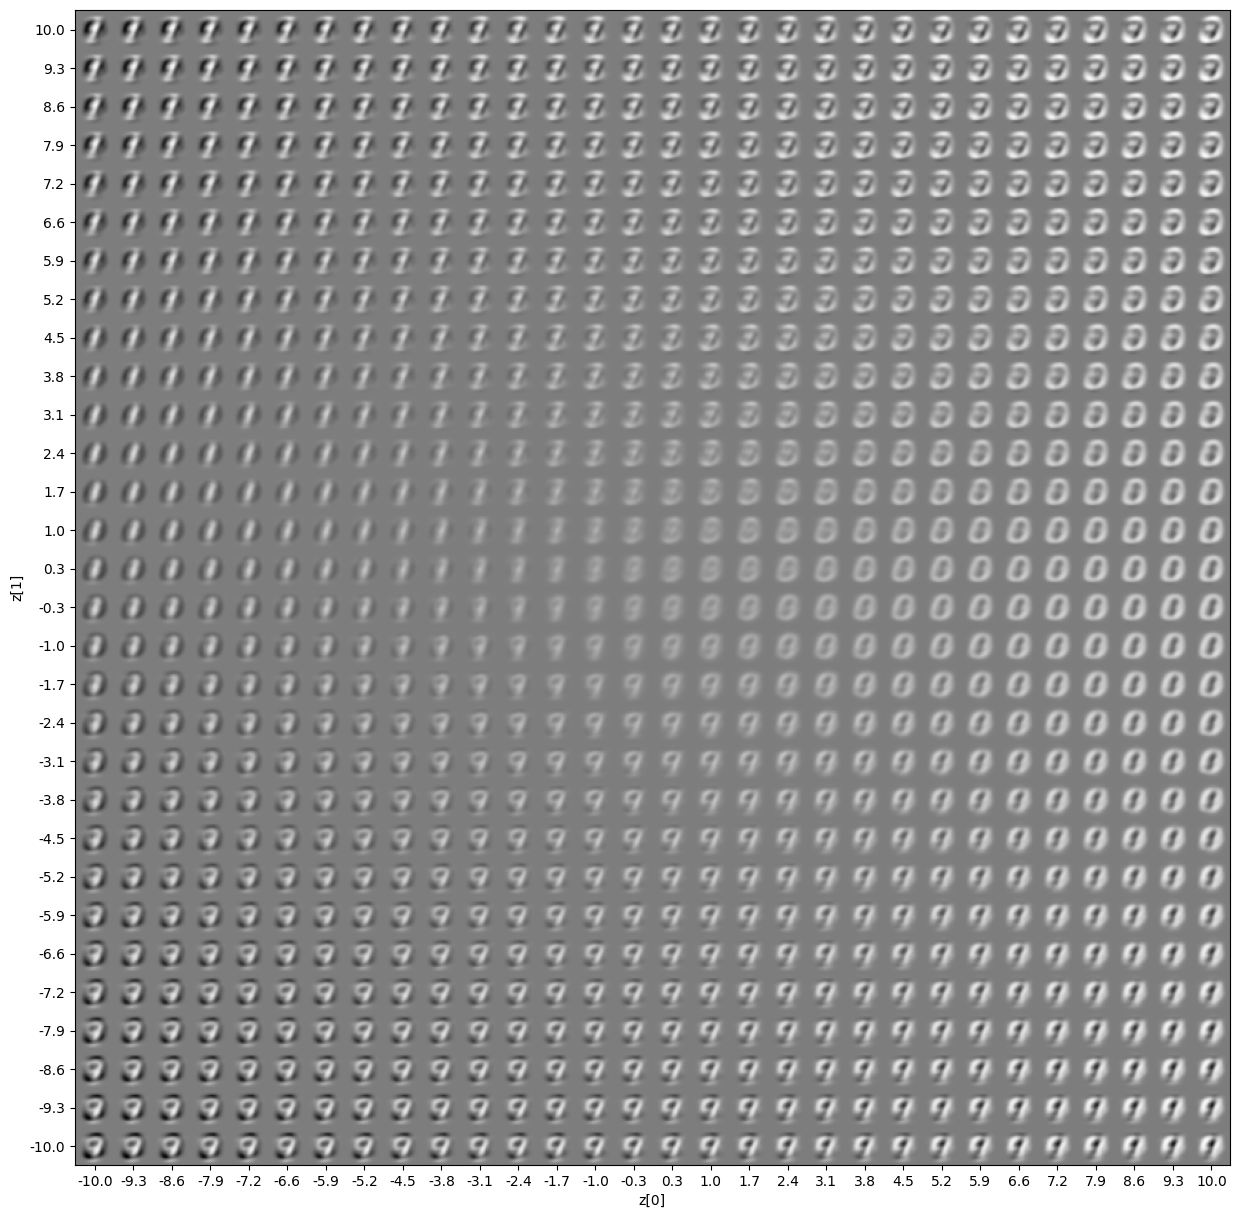

In [20]:
# plot of the map pca -> output

# draw a matrix nxn of images generated by the PCA, obtained by scanning the PCA dimensions [pca1,pca2]

def plot_latent_pca():
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 10
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([xi, yi]) #vector z
            x_decoded = pca.inverse_transform(z_sample) #inverse of the PCA transformation
            digit = x_decoded.reshape((28,28))
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    #print(pixel_range)
    #print(sample_range_x)
    #print(sample_range_y)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_pca()

## Use of the AS as Anomaly Detector

Anomaly detection describes a class of algorithms aimed at identifying rare elements, events, or observations that significantly deviate from the majority of the data and do not conform to a well-defined notion of normal behavior.

The idea is to train the autoencoder (AE) only on one type of event (normal ones), and then use the cross-entropy between the input and the reconstructed output, or an aggregation of the latent space (for example, the sum of the elements in z), as measures of anomaly. The expectation is that a normal event and an input event of a different type will be reconstructed differently by the AE and/or will have a different compressed latent representation.

As an example, let’s try training the AE only with the digit 0 and then see how it behaves when we feed it digit 1 characters.

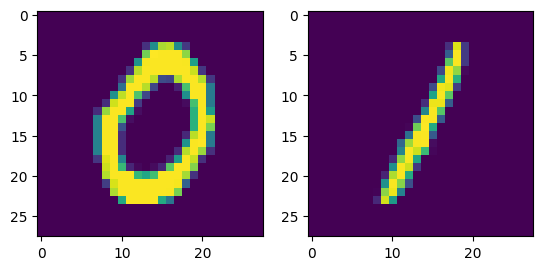

In [21]:
# build two datasets with MNIST characters 0 and 1

mnist0 = X_train[Y_train==0]
mnist1 = X_train[Y_train==1]

plt.subplot(1,2,1)
plt.imshow(mnist0[7].reshape((28,28)))
plt.subplot(1,2,2)
plt.imshow(mnist1[11].reshape((28,28)))

In [22]:
# convert in torch tensor

X0 = torch.Tensor(mnist0).float()
X1 = torch.Tensor(mnist1).float()

# reshape from (n,784) to (n,1,28,28)

X0 = X0.view((X0.shape[0],1,28,28))
X1 = X1.view((X1.shape[0],1,28,28))

X0_dataset = TensorDataset(X0, X0)

ds0, ds0t = torch.utils.data.random_split(X0_dataset, [int(0.9*len(X0_dataset)), len(X0_dataset) - int(0.9*len(X0_dataset))])

batch_size = 128

from torch.utils.data import TensorDataset, DataLoader

ds0_dl = DataLoader(ds0, batch_size=batch_size, shuffle=True, drop_last=True)

ds0t_dl = DataLoader(ds0t, batch_size=1, shuffle=True, drop_last=True)

ds1 = TensorDataset(X1, X1)
ds1_dl = DataLoader(ds1, batch_size=1, shuffle=True, drop_last=True)



In [25]:
# Training


hidden_channels = 64
latent_dim = 2 #latent space dimension

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)
model_ae = AE(encoder, decoder)

model_ae = model_ae.to(device)

# Loss Binary CrossEntropy
vae_loss = nn.BCELoss()


# Optimizer
LR = 1.e-3
opt = torch.optim.Adam(params=model_ae.parameters(), lr=LR, weight_decay=1e-5)

In [26]:
# Training loop

import time

epochs = 60
hist_loss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model_ae.train()
    train_loss = 0
    counter = 0

    for xb, _ in ds0_dl:
        counter += 1
        xb=xb.to(device)

        xhat = model_ae(xb)
        loss = vae_loss(xhat, xb)

        train_loss += loss.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    hist_loss.append(train_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f"
          % (epoch+1, elapsed_time, train_loss))

epoch: 1, time(s): 0.3315, train loss: 0.297364
epoch: 2, time(s): 0.2235, train loss: 0.218233
epoch: 3, time(s): 0.2271, train loss: 0.210103
epoch: 4, time(s): 0.2238, train loss: 0.203211
epoch: 5, time(s): 0.2299, train loss: 0.198046
epoch: 6, time(s): 0.2280, train loss: 0.195005
epoch: 7, time(s): 0.2246, train loss: 0.192132
epoch: 8, time(s): 0.2270, train loss: 0.190005
epoch: 9, time(s): 0.2271, train loss: 0.187810
epoch: 10, time(s): 0.2308, train loss: 0.186900
epoch: 11, time(s): 0.2276, train loss: 0.185466
epoch: 12, time(s): 0.2244, train loss: 0.184027
epoch: 13, time(s): 0.2271, train loss: 0.183442
epoch: 14, time(s): 0.2291, train loss: 0.182925
epoch: 15, time(s): 0.2352, train loss: 0.182503
epoch: 16, time(s): 0.2334, train loss: 0.181955
epoch: 17, time(s): 0.2459, train loss: 0.181736
epoch: 18, time(s): 0.2314, train loss: 0.181382
epoch: 19, time(s): 0.2320, train loss: 0.181117
epoch: 20, time(s): 0.2317, train loss: 0.180743
epoch: 21, time(s): 0.2350, t

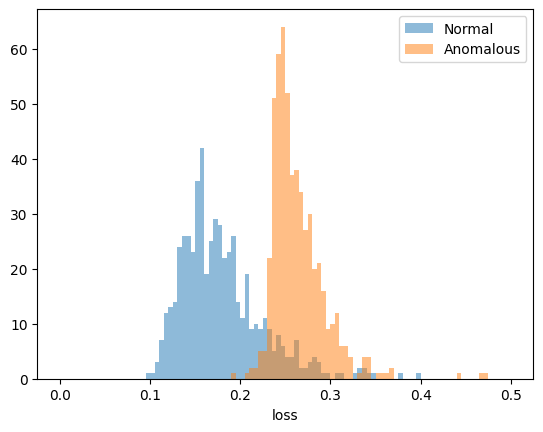

In [27]:
# Plot distribution of the BCELoss for test 0 and 1 events

model_ae.eval()

ev0_loss = []
ev1_loss = []

with torch.no_grad():
  for xb, _ in ds0t_dl:
    xb=xb.to(device)

    xhat = model_ae(xb)
    loss = vae_loss(xhat, xb)

    ev0_loss.append(loss.item())

  for xb, _ in ds1_dl:
    xb=xb.to(device)

    xhat = model_ae(xb)
    loss = vae_loss(xhat, xb)

    ev1_loss.append(loss.item())

plt.hist(ev0_loss, bins=100, range=[0,0.5], label='Normal', alpha=0.5)
plt.hist(ev1_loss[:len(ev0_loss)], bins=100, range=[0,0.5], label='Anomalous', alpha=0.5)
plt.xlabel("loss")
plt.legend()
plt.show()

## Part 2: exercise for you

Modify the model used for anomaly detection (AD) on characters 0 and 1 to perform anomaly detection on “images” (representations of hits recorded in a particle detector) produced by the passage of two different types of particles:

Short-lived (prompt) mother particles, which decay immediately into charged muons (whose passage is detected by the muon detector), and neutral Long-lived mother particles, which decay into muons only after traveling a macroscopic distance.
The former decay far from the muon detector, while the latter decay very close to it. As a result, the decay muons in the first case will arrive distributed in a wide cone centered on the direction of the mother particle, whereas in the second case the cone opening will be narrower.

In [29]:
# downlaod the dataset

!wget http://giagu.web.cern.ch/giagu/CERN/data_10v_downsampled.npz

f = np.load('data_10v_downsampled.npz')
data = f['data_noise']
labels = f['labels']

print("data:  ",data.shape)    #data_noise: 10k iamges detector hits  (10000, 20, 100)=(# events, radial coordinate, angular coordinate)
print("labels: ",labels.shape) #label: (10000, 3) = (# events, decay lenght (m), others not usefull) to be sued to select prompt  (decay lenght < 1m)
#                               from anomalous events (decay lenght > 3m)

--2025-06-19 06:55:10--  http://giagu.web.cern.ch/giagu/CERN/data_10v_downsampled.npz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.18.46, 188.185.50.104, 188.185.5.88, ...
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.18.46|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://giagu.web.cern.ch/giagu/CERN/data_10v_downsampled.npz [following]
--2025-06-19 06:55:11--  https://giagu.web.cern.ch/giagu/CERN/data_10v_downsampled.npz
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.18.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 480241008 (458M)
Saving to: ‘data_10v_downsampled.npz.1’

data_10v_downsample 100%[===================>] 457.99M  17.5MB/s    in 26s     

2025-06-19 06:55:38 (17.6 MB/s) - ‘data_10v_downsampled.npz.1’ saved [480241008/480241008]

data:   (10000, 20, 100)
labels:  (10000, 3)


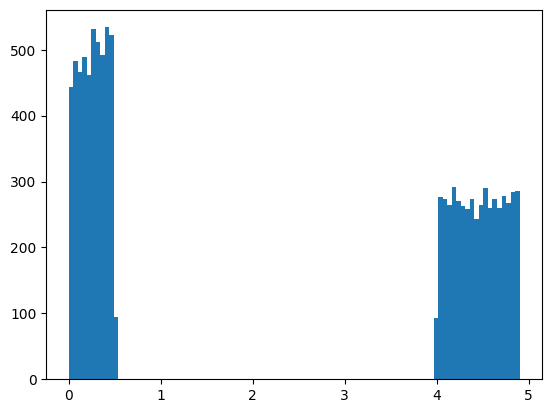

In [30]:
# decay lenght distribution:
import matplotlib.pyplot as plt
_ = plt.hist(labels[:,0], bins=100)

In [31]:
# preprocessing:

data[data>0]=1 #makes images binary (0 no hit in the detector cell, 1 hit in the detector cell)

# divide the sample in normal (decay lenght < 1m) and anomalous
labels = labels[:,0]
datax = data[labels<1.0] # normal
datat = datax[:4000] #training
datap = datax[4000:] # test
datad = data[labels>3.0] #anomalous (only test)

print(datat.shape)
print(datap.shape)
print(datad.shape)

(4000, 20, 100)
(1029, 20, 100)
(4971, 20, 100)


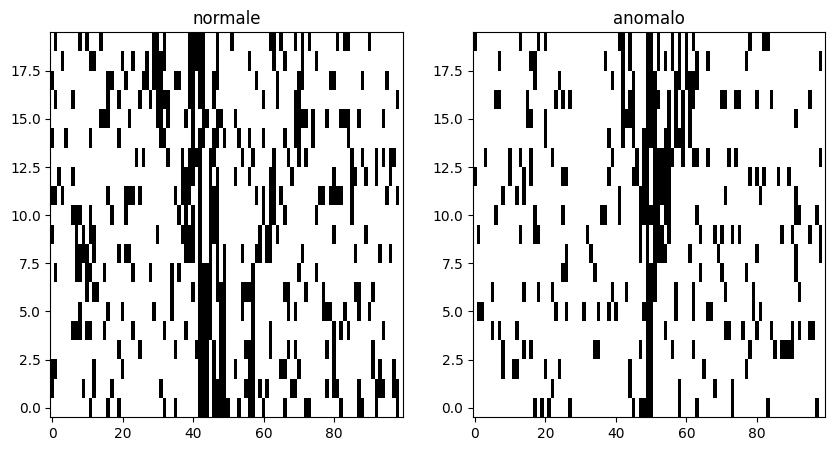

In [32]:
# example of a normal and anomalous event

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(datat[10], aspect='auto', origin='lower', cmap=plt.cm.binary)
plt.title('normale')
plt.subplot(1,2,2)
plt.imshow(datad[99], aspect='auto', origin='lower', cmap=plt.cm.binary)
plt.title('anomalo')
plt.show()

To do:


*   convert numpy -> pytorch tensors with shape (N, 1, 20, 100)
*   build a convolutional AE (hint: encoder: 3 convolutional blocks, first two with convolutions with kernels (3,6) and stride 2 (no pooling), third with stride (1,2), latent dim = 5.
*   use BCELoss()
*   tarin and test perfromances ...

In [ ]:
#...

# Solution

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import os

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.6.0+cu124


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
datat = np.expand_dims(datat, -1)
datap = np.expand_dims(datap, -1)
datad = np.expand_dims(datad, -1)

datat_pt = torch.Tensor(datat)
datap_pt = torch.Tensor(datap)
datad_pt = torch.Tensor(datad)

datat_pt = datat_pt.permute(0,3,1,2)
datap_pt = datap_pt.permute(0,3,1,2)
datad_pt = datad_pt.permute(0,3,1,2)

print(datat_pt.shape)
print(datap_pt.shape)
print(datad_pt.shape)

torch.Size([4000, 1, 20, 100])
torch.Size([1029, 1, 20, 100])
torch.Size([4971, 1, 20, 100])


In [ ]:
# Convolutional Encoder Model

class Encoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=hidden_channels*3,
                               kernel_size=(3,6),
                               stride=(2,2))

        self.conv2 = nn.Conv2d(in_channels=hidden_channels*3,
                               out_channels=hidden_channels*2,
                               kernel_size=(3,6),
                               stride=(2,2))

        self.conv3 = nn.Conv2d(in_channels=hidden_channels*2,
                               out_channels=hidden_channels,
                               kernel_size=(3,6),
                               stride=(1,2))

        self.fc_z = nn.Linear(in_features=hidden_channels*2*9,
                               out_features=latent_dim)

        self.activation = nn.ReLU()

    def forward(self, x):

        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))

        x = x.view(x.shape[0], -1) #flatten

        z = self.fc_z(x)

        return z

In [ ]:
# Convolutional Decoder Model

class Decoder(nn.Module):
    def __init__(self, hidden_channels=64, latent_dim=2):
        super().__init__()
        self.hidden_channels = hidden_channels

        self.fc = nn.Linear(in_features=latent_dim,
                            out_features=hidden_channels*2*9)

        self.conv3 = nn.ConvTranspose2d(in_channels=hidden_channels,
                                        out_channels=hidden_channels*2,
                                        kernel_size=(3,6),
                                        stride=(1,2))
        self.conv2 = nn.ConvTranspose2d(in_channels=hidden_channels*2,
                                        out_channels=hidden_channels*3,
                                        kernel_size=(3,6),
                                        stride=(2,2))
        self.conv1 = nn.ConvTranspose2d(in_channels=hidden_channels*3,
                                        out_channels=1,
                                        kernel_size=(3,6),
                                        stride=(2,2),output_padding=(1,0))

        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.hidden_channels, 2, 9)
        x = self.activation(self.conv3(x))
        x = self.activation(self.conv2(x))
        out = torch.sigmoid(self.conv1(x)) # final activation sigmoid (works with BCELoss as reconstruction loss)
        return out

In [ ]:

hidden_channels = 16
latent_dim = 5

encoder = Encoder(hidden_channels=hidden_channels, latent_dim=latent_dim)

print(encoder)

from torchsummary import summary
if torch.cuda.is_available():
  summary(encoder.cuda(), input_size=(1,20,100))
else:
  summary(encoder, input_size=(1,20,100))

Encoder(
  (conv1): Conv2d(1, 48, kernel_size=(3, 6), stride=(2, 2))
  (conv2): Conv2d(48, 32, kernel_size=(3, 6), stride=(2, 2))
  (conv3): Conv2d(32, 16, kernel_size=(3, 6), stride=(1, 2))
  (fc_z): Linear(in_features=288, out_features=5, bias=True)
  (activation): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 48, 9, 48]             912
              ReLU-2            [-1, 48, 9, 48]               0
            Conv2d-3            [-1, 32, 4, 22]          27,680
              ReLU-4            [-1, 32, 4, 22]               0
            Conv2d-5             [-1, 16, 2, 9]           9,232
              ReLU-6             [-1, 16, 2, 9]               0
            Linear-7                    [-1, 5]           1,445
Total params: 39,269
Trainable params: 39,269
Non-trainable params: 0
----------------------------------------------------------------
Input size 

In [ ]:
# idem for decoder

decoder = Decoder(hidden_channels=hidden_channels, latent_dim=latent_dim)

print(decoder)

from torchsummary import summary
if torch.cuda.is_available():
  summary(decoder.cuda(), input_size=(1,latent_dim))
else:
  summary(decoder, input_size=(1,latent_dim))


Decoder(
  (fc): Linear(in_features=5, out_features=288, bias=True)
  (conv3): ConvTranspose2d(16, 32, kernel_size=(3, 6), stride=(1, 2))
  (conv2): ConvTranspose2d(32, 48, kernel_size=(3, 6), stride=(2, 2))
  (conv1): ConvTranspose2d(48, 1, kernel_size=(3, 6), stride=(2, 2), output_padding=(1, 0))
  (activation): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 288]           1,728
   ConvTranspose2d-2            [-1, 32, 4, 22]           9,248
              ReLU-3            [-1, 32, 4, 22]               0
   ConvTranspose2d-4            [-1, 48, 9, 48]          27,696
              ReLU-5            [-1, 48, 9, 48]               0
   ConvTranspose2d-6           [-1, 1, 20, 100]             865
Total params: 39,537
Trainable params: 39,537
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forwa

In [ ]:
# Full AE Model

class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        x_reco = self.decoder(z)
        return x_reco

In [ ]:
model_ae = AE(encoder, decoder)

print(model_ae)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model_ae.cuda(), input_size=(1,20,100))
else:
  summary(model_ae, input_size=(1,20,100))

AE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 48, kernel_size=(3, 6), stride=(2, 2))
    (conv2): Conv2d(48, 32, kernel_size=(3, 6), stride=(2, 2))
    (conv3): Conv2d(32, 16, kernel_size=(3, 6), stride=(1, 2))
    (fc_z): Linear(in_features=288, out_features=5, bias=True)
    (activation): ReLU()
  )
  (decoder): Decoder(
    (fc): Linear(in_features=5, out_features=288, bias=True)
    (conv3): ConvTranspose2d(16, 32, kernel_size=(3, 6), stride=(1, 2))
    (conv2): ConvTranspose2d(32, 48, kernel_size=(3, 6), stride=(2, 2))
    (conv1): ConvTranspose2d(48, 1, kernel_size=(3, 6), stride=(2, 2), output_padding=(1, 0))
    (activation): ReLU()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 48, 9, 48]             912
              ReLU-2            [-1, 48, 9, 48]               0
            Conv2d-3            [-1, 32, 4, 22]          27,680
              ReLU-4 

In [ ]:
# dataloaders

from torch.utils.data import TensorDataset, DataLoader

batch_size=32

dataset_tt = TensorDataset(datat_pt,datat_pt)
dataloader_tt = DataLoader(dataset_tt, batch_size=batch_size, shuffle=True, drop_last=True)

dataset_tp = TensorDataset(datap_pt,datap_pt)
dataloader_tp = DataLoader(dataset_tp, batch_size=1)

dataset_td = TensorDataset(datad_pt,datad_pt)
dataloader_td = DataLoader(dataset_td, batch_size=1)

In [ ]:
# test
model_ae=model_ae.to(device)
x,_ = next(iter(dataloader_tt))
model_ae.to(device)
x=x.to(device)
xtilde = model_ae(x)
print(xtilde.shape)

torch.Size([32, 1, 20, 100])


In [ ]:
#loss

loss_func = nn.BCELoss()

# optim
from torch import optim
LR = 1.e-3
opt = torch.optim.Adam(params=model_ae.parameters(), lr=LR, weight_decay=1e-5)

In [ ]:
import time

epochs = 60
hist_loss = []

for epoch in range(epochs):
    t0 = time.time()

    # training step
    model_ae.train()
    train_loss = 0
    counter = 0

    for xb, _ in dataloader_tt:
        counter += 1
        xb=xb.to(device)

        xhat = model_ae(xb)
        loss = loss_func(xhat,xb)

        train_loss += loss.item()

        # backpropagation
        opt.zero_grad()
        loss.backward()
        opt.step()


    train_loss /= counter
    hist_loss.append(train_loss)

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f"
          % (epoch+1, elapsed_time, train_loss))

epoch: 1, time(s): 0.4828, train loss: 0.524593
epoch: 2, time(s): 0.4135, train loss: 0.505730
epoch: 3, time(s): 0.4178, train loss: 0.504407
epoch: 4, time(s): 0.4157, train loss: 0.503537
epoch: 5, time(s): 0.5245, train loss: 0.500940
epoch: 6, time(s): 0.5364, train loss: 0.497861
epoch: 7, time(s): 0.5167, train loss: 0.495564
epoch: 8, time(s): 0.5910, train loss: 0.494032
epoch: 9, time(s): 0.4585, train loss: 0.492660
epoch: 10, time(s): 0.4112, train loss: 0.491939
epoch: 11, time(s): 0.4156, train loss: 0.491395
epoch: 12, time(s): 0.4029, train loss: 0.491011
epoch: 13, time(s): 0.4104, train loss: 0.490621
epoch: 14, time(s): 0.4097, train loss: 0.490351
epoch: 15, time(s): 0.4044, train loss: 0.490110
epoch: 16, time(s): 0.4113, train loss: 0.489893
epoch: 17, time(s): 0.4100, train loss: 0.489655
epoch: 18, time(s): 0.4158, train loss: 0.489514
epoch: 19, time(s): 0.4184, train loss: 0.489344
epoch: 20, time(s): 0.4136, train loss: 0.489239
epoch: 21, time(s): 0.4154, t

In [ ]:
#  Anomaly Score computation
an_s = loss_func #let's use binary crossentropy as AS
model_ae.to(device)

as_tp = []
as_td = []
for xb, _ in dataloader_tp:
  xb=xb.to(device)
  pred_tp = model_ae(xb)
  res = an_s(pred_tp,xb)
  as_tp.append(res.item())

for xb, _ in dataloader_td:
  xb=xb.to(device)
  pred_td = model_ae(xb)
  res = an_s(pred_td,xb)
  as_td.append(res.item())

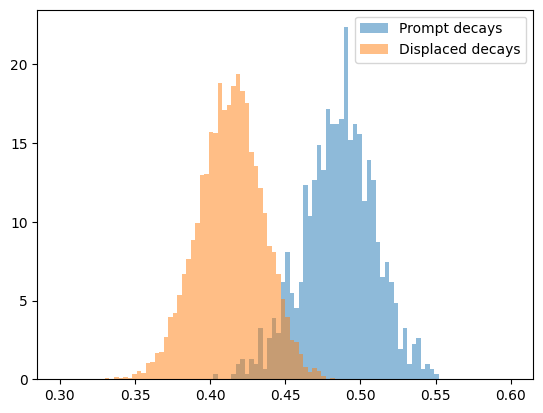

In [ ]:
import matplotlib.pyplot as plt

_ = plt.hist(as_tp,bins=100, alpha=0.5, density=True, range=[0.3,0.6], label='Prompt decays')
_ = plt.hist(as_td,bins=100, alpha=0.5, density=True, range=[0.3,0.6], label='Displaced decays')
plt.legend()
plt.show()